# Download and process SRA data

In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import pandas as pd
import numpy as np
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from core_acc_modules import utils, paths
from plotnine import (ggplot,
                      labs,  
                      geom_point,
                      aes, 
                      ggsave,
                      theme,
                      theme_bw,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


### Setup SRA toolkit

In [2]:
# Download latest version of compiled binaries of NCBI SRA toolkit 
if not os.path.exists("sratoolkit.current-centos_linux64.tar.gz"):
    ! wget "ftp://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-centos_linux64.tar.gz"

In [3]:
# Extract tar.gz file 
if os.path.exists("sratoolkit.current-centos_linux64.tar.gz"):
    ! tar -xzf sratoolkit.current-centos_linux64.tar.gz

# add binaries to path using export path or editing ~/.bashrc file
! export PATH=$PATH:sratoolkit.2.10.7-centos_linux64/bin

# Now SRA binaries added to path and ready to use

### Download SRA data

Two SRA projects were selected:
* [PRJNA633671](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA633671) 13 PAO1 samples isolated from pig burn wound after 3 (3), 14(5), 28(5) days post infection
* [PRJNA491911](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA491911) 15 PA14 samples isolated from pig burn wound after 3 (5), 14 (5), 28 (5) days post infection

In [4]:
# Download sra data files
! prefetch --option-file data/metadata/sra_acc.txt 


2020-07-10T21:33:47 prefetch.2.8.2: 1) 'SRR11809598' is found locally
2020-07-10T21:33:47 prefetch.2.8.2: 'SRR11809598' has 0 unresolved dependencies

2020-07-10T21:33:48 prefetch.2.8.2: 2) 'SRR11809599' is found locally
2020-07-10T21:33:48 prefetch.2.8.2: 'SRR11809599' has 0 unresolved dependencies

2020-07-10T21:33:49 prefetch.2.8.2: 3) 'SRR11809600' is found locally
2020-07-10T21:33:49 prefetch.2.8.2: 'SRR11809600' has 0 unresolved dependencies

2020-07-10T21:33:49 prefetch.2.8.2: 4) 'SRR11809601' is found locally
2020-07-10T21:33:49 prefetch.2.8.2: 'SRR11809601' has 0 unresolved dependencies

2020-07-10T21:33:49 prefetch.2.8.2: 5) 'SRR11809602' is found locally
2020-07-10T21:33:49 prefetch.2.8.2: 'SRR11809602' has 0 unresolved dependencies

2020-07-10T21:33:50 prefetch.2.8.2: 6) 'SRR11809603' is found locally
2020-07-10T21:33:50 prefetch.2.8.2: 'SRR11809603' has 0 unresolved dependencies

2020-07-10T21:33:50 prefetch.2.8.2: 7) 'SRR11809604' is found locally
2020-07-10T21:33:50 pre

### Get FASTQ files associated with SRA downloads

The fastq files store the RNA-seq results, including: sequencing and quality scores for each base call.

Here is a nice blog to explain how to read fastq files: https://thesequencingcenter.com/knowledge-base/fastq-files/

The fastq files gives the sequence of a read at a given location. Our goal is to map these reads to a reference genome so that we can quantify the number of reads that are at a given location, to determine the level of expression.

In [5]:
!mkdir $paths.FASTQ_DIR

mkdir: cannot create directory ‘/home/alexandra/ncbi/public/fastq’: File exists


In [6]:
!fastq-dump $paths.SRA_DIR/* --split-files --outdir $paths.FASTQ_DIR/

Read 2101445 spots for /home/alexandra/ncbi/public/sra/SRR11809598.sra
Written 2101445 spots for /home/alexandra/ncbi/public/sra/SRR11809598.sra
Read 2514613 spots for /home/alexandra/ncbi/public/sra/SRR11809599.sra
Written 2514613 spots for /home/alexandra/ncbi/public/sra/SRR11809599.sra
Read 1953843 spots for /home/alexandra/ncbi/public/sra/SRR11809600.sra
Written 1953843 spots for /home/alexandra/ncbi/public/sra/SRR11809600.sra
Read 1289288 spots for /home/alexandra/ncbi/public/sra/SRR11809601.sra
Written 1289288 spots for /home/alexandra/ncbi/public/sra/SRR11809601.sra
Read 2120994 spots for /home/alexandra/ncbi/public/sra/SRR11809602.sra
Written 2120994 spots for /home/alexandra/ncbi/public/sra/SRR11809602.sra
Read 1745161 spots for /home/alexandra/ncbi/public/sra/SRR11809603.sra
Written 1745161 spots for /home/alexandra/ncbi/public/sra/SRR11809603.sra
Read 2525033 spots for /home/alexandra/ncbi/public/sra/SRR11809604.sra
Written 2525033 spots for /home/alexandra/ncbi/public/sra/S

### Obtain a transcriptome and build an index

Here we are using [Salmon](https://combine-lab.github.io/salmon/)

**Input:**
* Target transcriptome
* This transcriptome is given to Salmon in the form of a (possibly compressed) multi-FASTA file, with each entry providing the sequence of a transcript
* DNA sequences (genes) that get transcribed as mRNA (transcripts). Should we look at reference transcipts or genes?
* We downloaded the `GENE DNA` file for `Pseudomonas aeruginosa PAO1 (Reference)` and `Pseudomonas aeruginosa UCBPP-PA14` from  http://www.pseudomonas.com/strain/download

**!!!** Georgia is using PAO1 reference from ensembl: ftp://ftp.ensemblgenomes.org/pub/bacteria/release-47/fasta/bacteria_13_collection/
Don't see an equivalent for PA14.

**Note:** For prokaryotes, transcripts and genes have a more 1-1 mapping so we're using genes for our reference transcriptome and so we don't need to use tximport to map transcript quants to genes. 

**Output:**
* The index is a structure that salmon uses to quasi-map RNA-seq reads during quantification
* [Quasi-map](https://academic.oup.com/bioinformatics/article/32/12/i192/2288985) is a way to map sequenced fragments (single or paired-end reads) to a target transcriptome. Quasi-mapping produces what we refer to as fragment mapping information. In particular, it provides, for each query (fragment), the reference sequences (transcripts), strand and position from which the query may have likely originated. In many cases, this mapping information is sufficient for downstream analysis like quantification.

*Algorithm:*

For a query read r through repeated application of: 
1. Determining the next hash table k-mer that starts past the current query position
2. Computing the maximum mappable prefix (MMP) of the query beginning with this k-mer
3. Determining the next informative position (NIP) by performing a longest common prefix (LCP) query on two specifically chosen suffixes in the SA

In [7]:
# Get PAO1 index
! salmon index -t $paths.PAO1_REF -i $paths.PAO1_INDEX

Version Info: This is the most recent version of salmon.
[2020-07-10 17:45:03.394] [jLog] [warning] The salmon index is being built without any decoy sequences.  It is recommended that decoy sequence (either computed auxiliary decoy sequence or the genome of the organism) be provided during indexing. Further details can be found at https://salmon.readthedocs.io/en/latest/salmon.html#preparing-transcriptome-indices-mapping-based-mode.
[2020-07-10 17:45:03.394] [jLog] [info] building index
out : /home/alexandra/Documents/Data/Core_accessory/pao1_index
[2020-07-10 17:45:03.394] [puff::index::jointLog] [info] Running fixFasta

[Step 1 of 4] : counting k-mers

[2020-07-10 17:45:03.791] [puff::index::jointLog] [warning] Removed 34 transcripts that were sequence duplicates of indexed transcripts.
[2020-07-10 17:45:03.791] [puff::index::jointLog] [warning] If you wish to retain duplicate transcripts, please use the `--keepDuplicates` flag
[2020-07-10 17:45:03.791] [puff::index::jointLog] [info

In [8]:
# Get PA14 index
! salmon index -t $paths.PA14_REF -i $paths.PA14_INDEX

Version Info: This is the most recent version of salmon.
[2020-07-10 17:45:07.120] [jLog] [warning] The salmon index is being built without any decoy sequences.  It is recommended that decoy sequence (either computed auxiliary decoy sequence or the genome of the organism) be provided during indexing. Further details can be found at https://salmon.readthedocs.io/en/latest/salmon.html#preparing-transcriptome-indices-mapping-based-mode.
[2020-07-10 17:45:07.120] [jLog] [info] building index
out : /home/alexandra/Documents/Data/Core_accessory/pa14_index
[2020-07-10 17:45:07.120] [puff::index::jointLog] [info] Running fixFasta

[Step 1 of 4] : counting k-mers

[2020-07-10 17:45:07.333] [puff::index::jointLog] [warning] Removed 37 transcripts that were sequence duplicates of indexed transcripts.
[2020-07-10 17:45:07.333] [puff::index::jointLog] [warning] If you wish to retain duplicate transcripts, please use the `--keepDuplicates` flag
[2020-07-10 17:45:07.334] [puff::index::jointLog] [info

### Quantify gene expression
Now that we have our index built and all of our data downloaded, we’re ready to quantify our samples

**Input:**
* Index of reference transcriptome
* FASTQ of experimental samples

**Output:**

After the salmon commands finish running, you should have a directory named quants, which will have a sub-directory for each sample. These sub-directories contain the quantification results of salmon, as well as a lot of other information salmon records about the sample and the run. 

The main output file (called `quant.sf`). Inside the quantification file for sample DRR016125 in quants/DRR016125/quant.sf, you’ll see a TSV format file listing the name (`Name`) of each transcript, its length (`Length`), effective length (`EffectiveLength`), and its abundance in terms of Transcripts Per Million (`TPM`) and estimated number of reads (`NumReads`) originating from this transcript.

**For each sample we have read counts per gene (where the genes are based on the reference gene file provided above).** 

#### Get quants using PAO1 reference

In [15]:
%%bash -s $paths.PAO1_QUANT $paths.FASTQ_DIR $paths.PAO1_INDEX
mkdir $1

for FILE_PATH in $2/*;
do

# get file name
sample_name=`basename ${FILE_PATH}`

# remove extension from file name
sample_name="${sample_name%_*}"

# get base path
base_name=${FILE_PATH%/*}

echo "Processing sample ${sample_name}"

salmon quant -i $3 -l A \
            -1 ${base_name}/${sample_name}_1.fastq \
            -2 ${base_name}/${sample_name}_2.fastq \
            -p 8 --validateMappings -o $1/${sample_name}_quant
done

Processing sample SRR11809598
Processing sample SRR11809598
Processing sample SRR11809599
Processing sample SRR11809599
Processing sample SRR11809600
Processing sample SRR11809600
Processing sample SRR11809601
Processing sample SRR11809601
Processing sample SRR11809602
Processing sample SRR11809602
Processing sample SRR11809603
Processing sample SRR11809603
Processing sample SRR11809604
Processing sample SRR11809604
Processing sample SRR11809605
Processing sample SRR11809605
Processing sample SRR11809606
Processing sample SRR11809606
Processing sample SRR11809607
Processing sample SRR11809607
Processing sample SRR11809626
Processing sample SRR11809626
Processing sample SRR11809627
Processing sample SRR11809627
Processing sample SRR11809628
Processing sample SRR11809628
Processing sample SRR7886554
Processing sample SRR7886554
Processing sample SRR7886555
Processing sample SRR7886555
Processing sample SRR7886556
Processing sample SRR7886556
Processing sample SRR7886557
Processing sample

mkdir: cannot create directory ‘/home/alexandra/ncbi/public/quants_pao1’: File exists
Version Info: This is the most recent version of salmon.
### salmon (selective-alignment-based) v1.3.0
### [ program ] => salmon 
### [ command ] => quant 
### [ index ] => { /home/alexandra/Documents/Data/Core_accessory/pao1_index }
### [ libType ] => { A }
### [ mates1 ] => { /home/alexandra/ncbi/public/fastq/SRR11809598_1.fastq }
### [ mates2 ] => { /home/alexandra/ncbi/public/fastq/SRR11809598_2.fastq }
### [ threads ] => { 8 }
### [ validateMappings ] => { }
### [ output ] => { /home/alexandra/ncbi/public/quants_pao1/SRR11809598_quant }
Logs will be written to /home/alexandra/ncbi/public/quants_pao1/SRR11809598_quant/logs
[2020-07-10 17:55:39.850] [jointLog] [info] setting maxHashResizeThreads to 8
[2020-07-10 17:55:39.850] [jointLog] [info] Fragment incompatibility prior below threshold.  Incompatible fragments will be ignored.
[2020-07-10 17:55:39.850] [jointLog] [info] Usage of --validateMappi

#### Get quants using PA14 reference

In [16]:
%%bash -s $paths.PA14_QUANT $paths.FASTQ_DIR $paths.PA14_INDEX
mkdir $1

for FILE_PATH in $2/*;
do

# get file name
sample_name=`basename ${FILE_PATH}`

# remove extension from file name
sample_name="${sample_name%_*}"

# get base path
base_name=${FILE_PATH%/*}

echo "Processing sample ${sample_name}"

salmon quant -i $3 -l A \
            -1 ${base_name}/${sample_name}_1.fastq \
            -2 ${base_name}/${sample_name}_2.fastq \
            -p 8 --validateMappings -o $1/${sample_name}_quant
done

Processing sample SRR11809598
Processing sample SRR11809598
Processing sample SRR11809599
Processing sample SRR11809599
Processing sample SRR11809600
Processing sample SRR11809600
Processing sample SRR11809601
Processing sample SRR11809601
Processing sample SRR11809602
Processing sample SRR11809602
Processing sample SRR11809603
Processing sample SRR11809603
Processing sample SRR11809604
Processing sample SRR11809604
Processing sample SRR11809605
Processing sample SRR11809605
Processing sample SRR11809606
Processing sample SRR11809606
Processing sample SRR11809607
Processing sample SRR11809607
Processing sample SRR11809626
Processing sample SRR11809626
Processing sample SRR11809627
Processing sample SRR11809627
Processing sample SRR11809628
Processing sample SRR11809628
Processing sample SRR7886554
Processing sample SRR7886554
Processing sample SRR7886555
Processing sample SRR7886555
Processing sample SRR7886556
Processing sample SRR7886556
Processing sample SRR7886557
Processing sample

mkdir: cannot create directory ‘/home/alexandra/ncbi/public/quants_pa14’: File exists
Version Info: This is the most recent version of salmon.
### salmon (selective-alignment-based) v1.3.0
### [ program ] => salmon 
### [ command ] => quant 
### [ index ] => { /home/alexandra/Documents/Data/Core_accessory/pa14_index }
### [ libType ] => { A }
### [ mates1 ] => { /home/alexandra/ncbi/public/fastq/SRR11809598_1.fastq }
### [ mates2 ] => { /home/alexandra/ncbi/public/fastq/SRR11809598_2.fastq }
### [ threads ] => { 8 }
### [ validateMappings ] => { }
### [ output ] => { /home/alexandra/ncbi/public/quants_pa14/SRR11809598_quant }
Logs will be written to /home/alexandra/ncbi/public/quants_pa14/SRR11809598_quant/logs
[2020-07-10 18:02:25.110] [jointLog] [info] setting maxHashResizeThreads to 8
[2020-07-10 18:02:25.110] [jointLog] [info] Fragment incompatibility prior below threshold.  Incompatible fragments will be ignored.
[2020-07-10 18:02:25.110] [jointLog] [info] Usage of --validateMappi

### Consolidate sample quantification to gene expression dataframe

In [19]:
# PAO1
# Read through all sample subdirectories in quant/
# Within each sample subdirectory, get quant.sf file
data_dir = paths.PAO1_QUANT

expression_pao1_df = pd.DataFrame(
    pd.read_csv(file, sep="\t", index_col=0)["TPM"].
    rename(file.parent.name.split("_")[0]) 
    for file in data_dir.rglob("*/quant.sf"))    

expression_pao1_df.head()

Name,PGD134012,PGD134018,PGD134020,PGD134022,PGD134024,PGD134014,PGD134016,PGD134026,PGD134030,PGD134032,...,PGD133904,PGD133906,PGD133902,PGD133898,PGD133900,PGD133894,PGD133896,PGD133892,PGD133884,PGD133886
SRR7886564,231.727925,190.752886,251.448610,244.585583,232.686707,338.820203,154.626626,135.315075,197.310154,208.679566,...,384.066668,160.434425,217.478638,156.902095,207.885018,401.518691,243.889759,243.003681,246.352130,2479.579675
SRR7886563,221.834080,206.206472,262.483160,236.195679,218.755932,277.160969,172.748364,131.637931,203.887568,195.415181,...,422.452539,186.054579,221.781202,169.886555,206.020813,364.555070,220.690228,222.109424,290.783303,1831.554781
SRR7886556,239.045868,214.727176,274.768536,234.910876,211.436253,331.034365,182.542018,151.795905,177.397021,214.474633,...,313.586824,203.429113,219.471726,122.120857,216.627876,356.444332,204.944743,236.929805,344.241759,837.205098
SRR7886554,207.552313,225.561545,225.270938,219.551817,187.828643,288.607561,170.661308,153.005215,178.959993,189.223026,...,310.729195,162.022883,226.711482,151.330882,188.408437,344.356431,230.655350,215.722543,231.656256,2791.117704
SRR11809604,260.582412,246.795620,266.233942,265.958700,221.246325,326.505589,168.106500,173.741073,222.383686,211.503821,...,407.473085,218.518712,230.017515,167.595262,229.037474,375.975401,245.805061,271.981486,330.459423,3022.965440


In [20]:
# PA14
data_dir = paths.PA14_QUANT

expression_pa14_df = pd.DataFrame(
    pd.read_csv(file, sep="\t", index_col=0)["TPM"].
    rename(file.parent.name.split("_")[0]) 
    for file in data_dir.rglob("*/quant.sf"))    

expression_pa14_df.head()

Name,PGD1650835,PGD1650837,PGD1650839,PGD1650841,PGD1650843,PGD1650845,PGD1650847,PGD1650849,PGD1650851,PGD1650853,...,PGD1662756,PGD1662758,PGD1662760,PGD1662762,PGD1662764,PGD1662766,PGD1662768,PGD1662770,PGD1662772,PGD1662774
SRR7886564,192.776253,158.738776,214.650260,202.810084,191.195412,284.391640,128.594844,111.769716,169.512195,181.968188,...,206.299583,318.378269,137.664654,176.701651,128.919102,172.663947,325.009257,207.794688,203.663767,198.203437
SRR7886563,185.988041,176.442510,226.765845,199.519591,181.199320,239.847143,148.186519,112.661285,173.916604,171.601658,...,214.478834,349.057248,160.862620,179.751915,147.525512,173.588342,327.560246,190.274716,187.378163,233.735965
SRR7886556,206.736887,182.719745,239.183592,204.331068,177.183021,281.309219,156.840906,130.625679,157.577567,183.598426,...,184.607694,266.250506,176.677582,187.723010,108.814079,185.372625,340.092035,179.364051,204.724174,291.333307
SRR7886554,178.727605,195.424985,192.620807,189.725119,163.125665,247.958087,147.771531,131.753387,154.785446,166.717385,...,194.715211,275.866339,140.862756,185.989760,128.568856,161.749673,316.988401,199.497856,185.449570,196.161006
SRR11809604,267.197303,254.726406,268.658578,271.448308,230.774390,333.436405,172.398882,176.986401,226.548965,217.946435,...,282.897817,416.363490,217.930763,242.684574,166.946718,234.819859,360.386167,248.585134,279.118226,340.234573


In [22]:
# Map gene ids to gene names
pa14_fasta_file = paths.PA14_REF
pao1_fasta_file = paths.PAO1_REF

seq_id_to_gene_id_pao1 = utils.dict_gene_num_to_ids(pao1_fasta_file)
seq_id_to_gene_id_pa14 = utils.dict_gene_num_to_ids(pa14_fasta_file)

expression_pao1_df.rename(mapper=seq_id_to_gene_id_pao1, axis="columns", inplace=True)
expression_pa14_df.rename(mapper=seq_id_to_gene_id_pa14, axis="columns", inplace=True)

### Quick validation
Here we want to validate that we've processed the samples correctly using Salmon.

In [23]:
# Load in gene annotation file
gene_annot_file = os.path.join(
        "data",
        "metadata",
        "selected_gene_annotations.txt")

core_genes, acc_genes = utils.get_core_acc_genes(gene_annot_file)

In [24]:
# Load in sample annotation file
sample_annot_file = os.path.join(
        "data",
        "metadata",
        "sample_groups.txt")

pao1_ids, pa14_ids = utils.get_sample_grps(sample_annot_file)

In [25]:
# Examine PA14 samples in PAO1-specific genes (PAO1 reference)
pa14_samples_pao1_genes_pao1_ref = expression_pao1_df.loc[pa14_ids,acc_genes]
pa14_samples_pao1_genes_pao1_ref_mean = pa14_samples_pao1_genes_pao1_ref.mean()
pa14_samples_pao1_genes_pao1_ref_mean.isna().any()

False

In [26]:
# Examine PA14 samples in core genes
pa14_samples_core_genes_pao1_ref = expression_pao1_df.loc[pa14_ids,core_genes]
pa14_samples_core_genes_pao1_ref_mean = pa14_samples_core_genes_pao1_ref.mean()
pa14_samples_core_genes_pao1_ref_mean.isna().any()
pa14_samples_core_genes_pao1_ref_mean[pa14_samples_core_genes_pao1_ref_mean.isna()]

Name
PA2401   NaN
dtype: float64

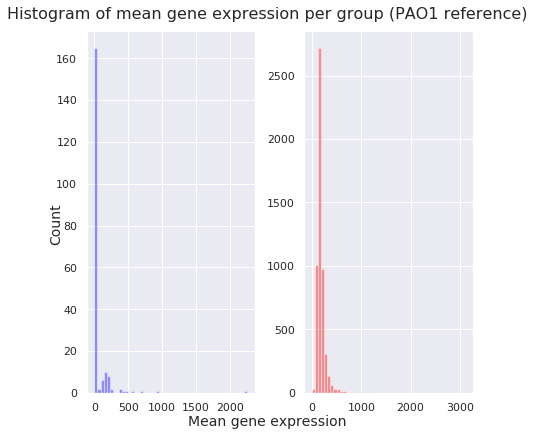

In [27]:
# Plot
sns.set()

# Set up the matplotlib figure
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(6,6))

# Distribution plot for core genes
sns.distplot(pa14_samples_pao1_genes_pao1_ref_mean.values, 
             label='PA14 samples PAO1 specific genes', 
             color='blue',
             #bins=bins_expression,
             kde=False,
             ax=axes[0]
            )

sns.distplot(pa14_samples_core_genes_pao1_ref_mean.values,
             label='PA14 samples core genes',
             color='red',
             #bins=bins_expression,
             kde=False,
             ax=axes[1]
            )
fig.xlim=(0,10)
plt.suptitle('Histogram of mean gene expression per group (PAO1 reference)',
            fontsize=16)
fig.text(0.5, 0.01, 'Mean gene expression', ha='center', fontsize=14)
fig.text(0.01, 0.5, 'Count', ha='center', rotation=90, fontsize=14)
plt.tight_layout(pad=0.4, 
                 w_pad=0.5,
                 h_pad=1.0,
                 rect=[0, 0.03, 1, 0.95])


**Takeaway**:
The plot above is taking all PA14 samples and looking at the distribution of mean gene expression(across samples) in two cases: (blue) mean gene expression for PAO1-specific genes (i.e. genes absent in PA14 strains) and (red) mean gene expression for core genes (i.e. genes shared by both PAO1 and PA14 strains). 

If we processed the data correctly, we'd expect that gnes that are PAO1-specific (ie. those PAO1 genes that do not have a PA14 homolog) have 0 mainly expression in PA14 samples. We do see this - blue has many genes that have 0 mean gene expression while the red does not. 

#### Visualize clustering of gene expression

In [28]:
# Embed expression data into low dimensional space
model = umap.UMAP(random_state=123).fit(expression_pao1_df)
pao1_encoded = model.transform(expression_pao1_df)

pao1_encoded_df = pd.DataFrame(data=pao1_encoded,
                               index=expression_pao1_df.index,
                               columns=['1','2'])

# Add label
pao1_encoded_df['genotype'] = 'PAO1'
pao1_encoded_df.loc[pa14_ids,'genotype'] = 'PA14'

pao1_encoded_df.head()

,1,2,genotype
SRR7886564,6.431922,25.153227,PA14
SRR7886563,6.810697,24.330374,PA14
SRR7886556,6.993403,24.729055,PA14
SRR7886554,6.840775,25.420719,PA14
SRR11809604,4.705234,14.855809,PAO1


In [29]:
# Embed expression data into low dimensional space
model = umap.UMAP(random_state=123).fit(expression_pa14_df)
pa14_encoded = model.transform(expression_pa14_df)

pa14_encoded_df = pd.DataFrame(data=pa14_encoded,
                               index=expression_pa14_df.index,
                               columns=['1','2'])

# Add label
pa14_encoded_df['genotype'] = 'PAO1'
pa14_encoded_df.loc[pa14_ids,'genotype'] = 'PA14'

pa14_encoded_df.head()

,1,2,genotype
SRR7886564,13.529325,9.878489,PA14
SRR7886563,13.010225,8.672278,PA14
SRR7886556,14.537167,9.459736,PA14
SRR7886554,15.334528,9.259426,PA14
SRR11809604,-1.938706,-2.437612,PAO1


/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


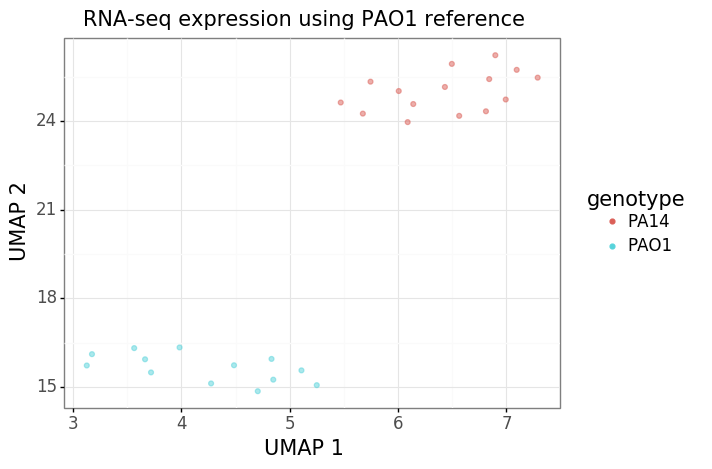

<ggplot: (8794565499445)>


In [30]:
# Plot PAO1
fig = ggplot(pao1_encoded_df, aes(x='1', y='2'))
fig += geom_point(aes(color='genotype'), alpha=0.5)
fig += labs(x ='UMAP 1',
            y = 'UMAP 2',
            title = 'RNA-seq expression using PAO1 reference')
fig += theme_bw()
fig += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    legend_title=element_text(family='sans-serif', size=15),
    legend_text=element_text(family='sans-serif', size=12),
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)
    )
fig += guides(colour=guide_legend(override_aes={'alpha': 1}))

print(fig)

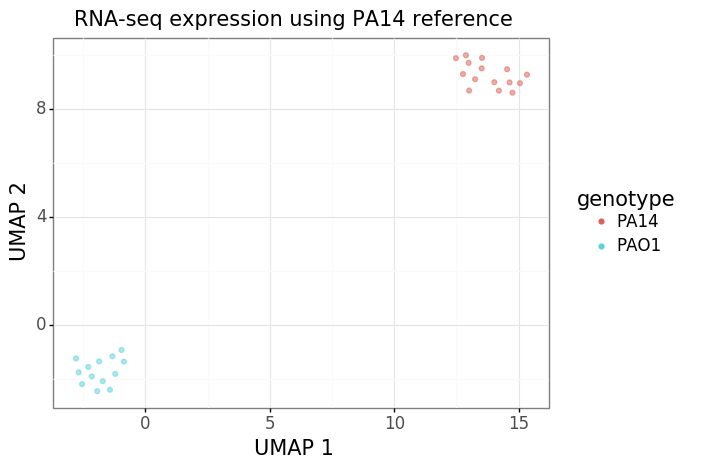

<ggplot: (8794565072561)>


In [31]:
# Plot PA14
fig = ggplot(pa14_encoded_df, aes(x='1', y='2'))
fig += geom_point(aes(color='genotype'), alpha=0.5)
fig += labs(x ='UMAP 1',
            y = 'UMAP 2',
            title = 'RNA-seq expression using PA14 reference')
fig += theme_bw()
fig += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    legend_title=element_text(family='sans-serif', size=15),
    legend_text=element_text(family='sans-serif', size=12),
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)
    )
fig += guides(colour=guide_legend(override_aes={'alpha': 1}))

print(fig)

**Takeaway:**
This plot is showing the clustering of samples using both the PAO1 reference transcriptome and the PA14 reference transcriptome. The plot shows that the samples clustering by genotype, as expected.